## Описание проекта. Телеком


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. 

Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 

Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг
Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. 

Доступны различные способы расчёта и возможность получить электронный чек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

from sqlalchemy import create_engine 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import ( 
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold
)

from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.compose import ColumnTransformer
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    make_scorer,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)

from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

RANDOM_STATE = 270822

## Описание данных

Таблица contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Загрузка данных

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-final' # название базы данных,
}
 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string) 

In [3]:
contract = pd.read_sql_query('''
SELECT * FROM telecom.contract
''', con=engine) 

personal = pd.read_sql_query('''
SELECT * FROM telecom.personal
''', con=engine) 

internet = pd.read_sql_query('''
SELECT * FROM telecom.internet
''', con=engine) 

phone = pd.read_sql_query('''
SELECT * FROM telecom.phone
''', con=engine)

In [4]:
print(contract.info())
display(contract.head(10))

print(personal.info())
display(personal.head(10))

print(internet.info())
display(internet.head(10))

print(phone.info())
display(phone.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB
None


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


In [5]:
internet.columns = internet.iloc[0].values
internet = internet.iloc[1:].reset_index(drop=True)

phone.columns = phone.iloc[0].values
phone = phone.iloc[1:].reset_index(drop=True)


In [6]:
display(phone.head())
display(internet.head())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [7]:
contract['Target'] = contract['EndDate'].isna().astype(int)

### Вывод:
Был создан Target из EndDate, изменен формат internet и phone, чтобы корректно отобразить названия колонок.

## Исследовательский анализ и предобработка данных

Найдем причину пропусков в TotalCharges. Как видно это потому, что дата начала это 01/02/2020, то есть TotalCharges = MonthlyCharges.

Заполним пропуски и преобразуем типы.

In [8]:
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN,1
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN,1
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN,1
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN,1
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN,1
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN,1
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN,1
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN,1
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN,1


In [9]:
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = contract['MonthlyCharges']
contract['EndDate'] = contract['EndDate'].fillna('2020-02-01')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [10]:
contract['Target'].value_counts()

1    5174
0    1869
Name: Target, dtype: int64

Видим дисбаланс, позже используем imblearn

In [11]:
print(contract.info())
display(contract.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,1
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,1
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,1
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,0
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,25.75,1
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,56.05,1
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,0
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,25.35,1


Контракты есть у всех но кто-то пользуется интернетом, кто-то телефоном, а кто-то и тем и другим. Смерджим данные.

In [12]:
df = contract.merge(personal, on='customerID').merge(internet, how='left', on='customerID').merge(phone, how='left', on='customerID')

In [13]:
df = df.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})

In [14]:
display(df.head())
print(df.info())
display(df.describe())

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,1,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,1,Male,...,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,0,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,1,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

,MonthlyCharges,TotalCharges,Target,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.798992,0.734630,0.162147
std,30.090047,2266.730170,0.441561,0.368612
min,18.250000,18.800000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,0.000000
50%,70.350000,1394.550000,1.000000,0.000000
75%,89.850000,3786.600000,1.000000,0.000000
max,118.750000,8684.800000,1.000000,1.000000


In [15]:
na_columns = df.columns[df.isna().sum().astype(bool)]
for i in na_columns:
    print(df[i].unique())

['DSL' nan 'Fiber optic']
['Yes' nan 'No']
['No' nan 'Yes']
['Yes' nan 'No']
['Yes' nan 'No']
['Yes' nan 'No']
['No' nan 'Yes']
[nan 'No' 'Yes']


Заполним пропуски 'No', для интернета это тоже будет логично, еcли интернета нет - значение 'No'.

In [16]:
for i in na_columns:
    df[i] = df[i].fillna('No')

In [17]:
len(df['CustomerID'].unique())

7043

На всякий случай проверим уникальность CustomerID, оно = числу строк, все ок.

In [18]:
print(df['SeniorCitizen'].value_counts())
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

0    5901
1    1142
Name: SeniorCitizen, dtype: int64


Добавим числовой признак - разницу между начальной и конечной датой, в днях

In [19]:
df['Days'] = (df['EndDate'] - df['BeginDate']).dt.days

In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int32         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int32         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [21]:
categorical = [
    'Type', 
    'PaperlessBilling', 
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines'
]

continuous = [
    'Days',
    'MonthlyCharges', 
    'TotalCharges'
]

target = 'Target'

Даты использовать не будем, остальные колонки берем.

In [22]:
df[continuous + [target]].corr()

,Days,MonthlyCharges,TotalCharges,Target
Days,1.000000,-0.011267,-0.010554,-0.018664
MonthlyCharges,-0.011267,1.000000,0.651182,-0.193356
TotalCharges,-0.010554,0.651182,1.000000,0.198347
Target,-0.018664,-0.193356,0.198347,1.000000


Интересно, что время, которое человек был клиентом, мало влияет на вероятность отказа от услуг. 

Можно было предположить, что этот фактор повлияет сильнее, но в основном влияет сумма.

In [23]:
for i in categorical:
    print(i, df[i].unique())

Type ['Two year' 'Month-to-month' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
Gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['Yes' 'No']
InternetService ['DSL' 'No' 'Fiber optic']
OnlineSecurity ['Yes' 'No']
OnlineBackup ['No' 'Yes']
DeviceProtection ['Yes' 'No']
TechSupport ['Yes' 'No']
StreamingTV ['Yes' 'No']
StreamingMovies ['No' 'Yes']
MultipleLines ['No' 'Yes']


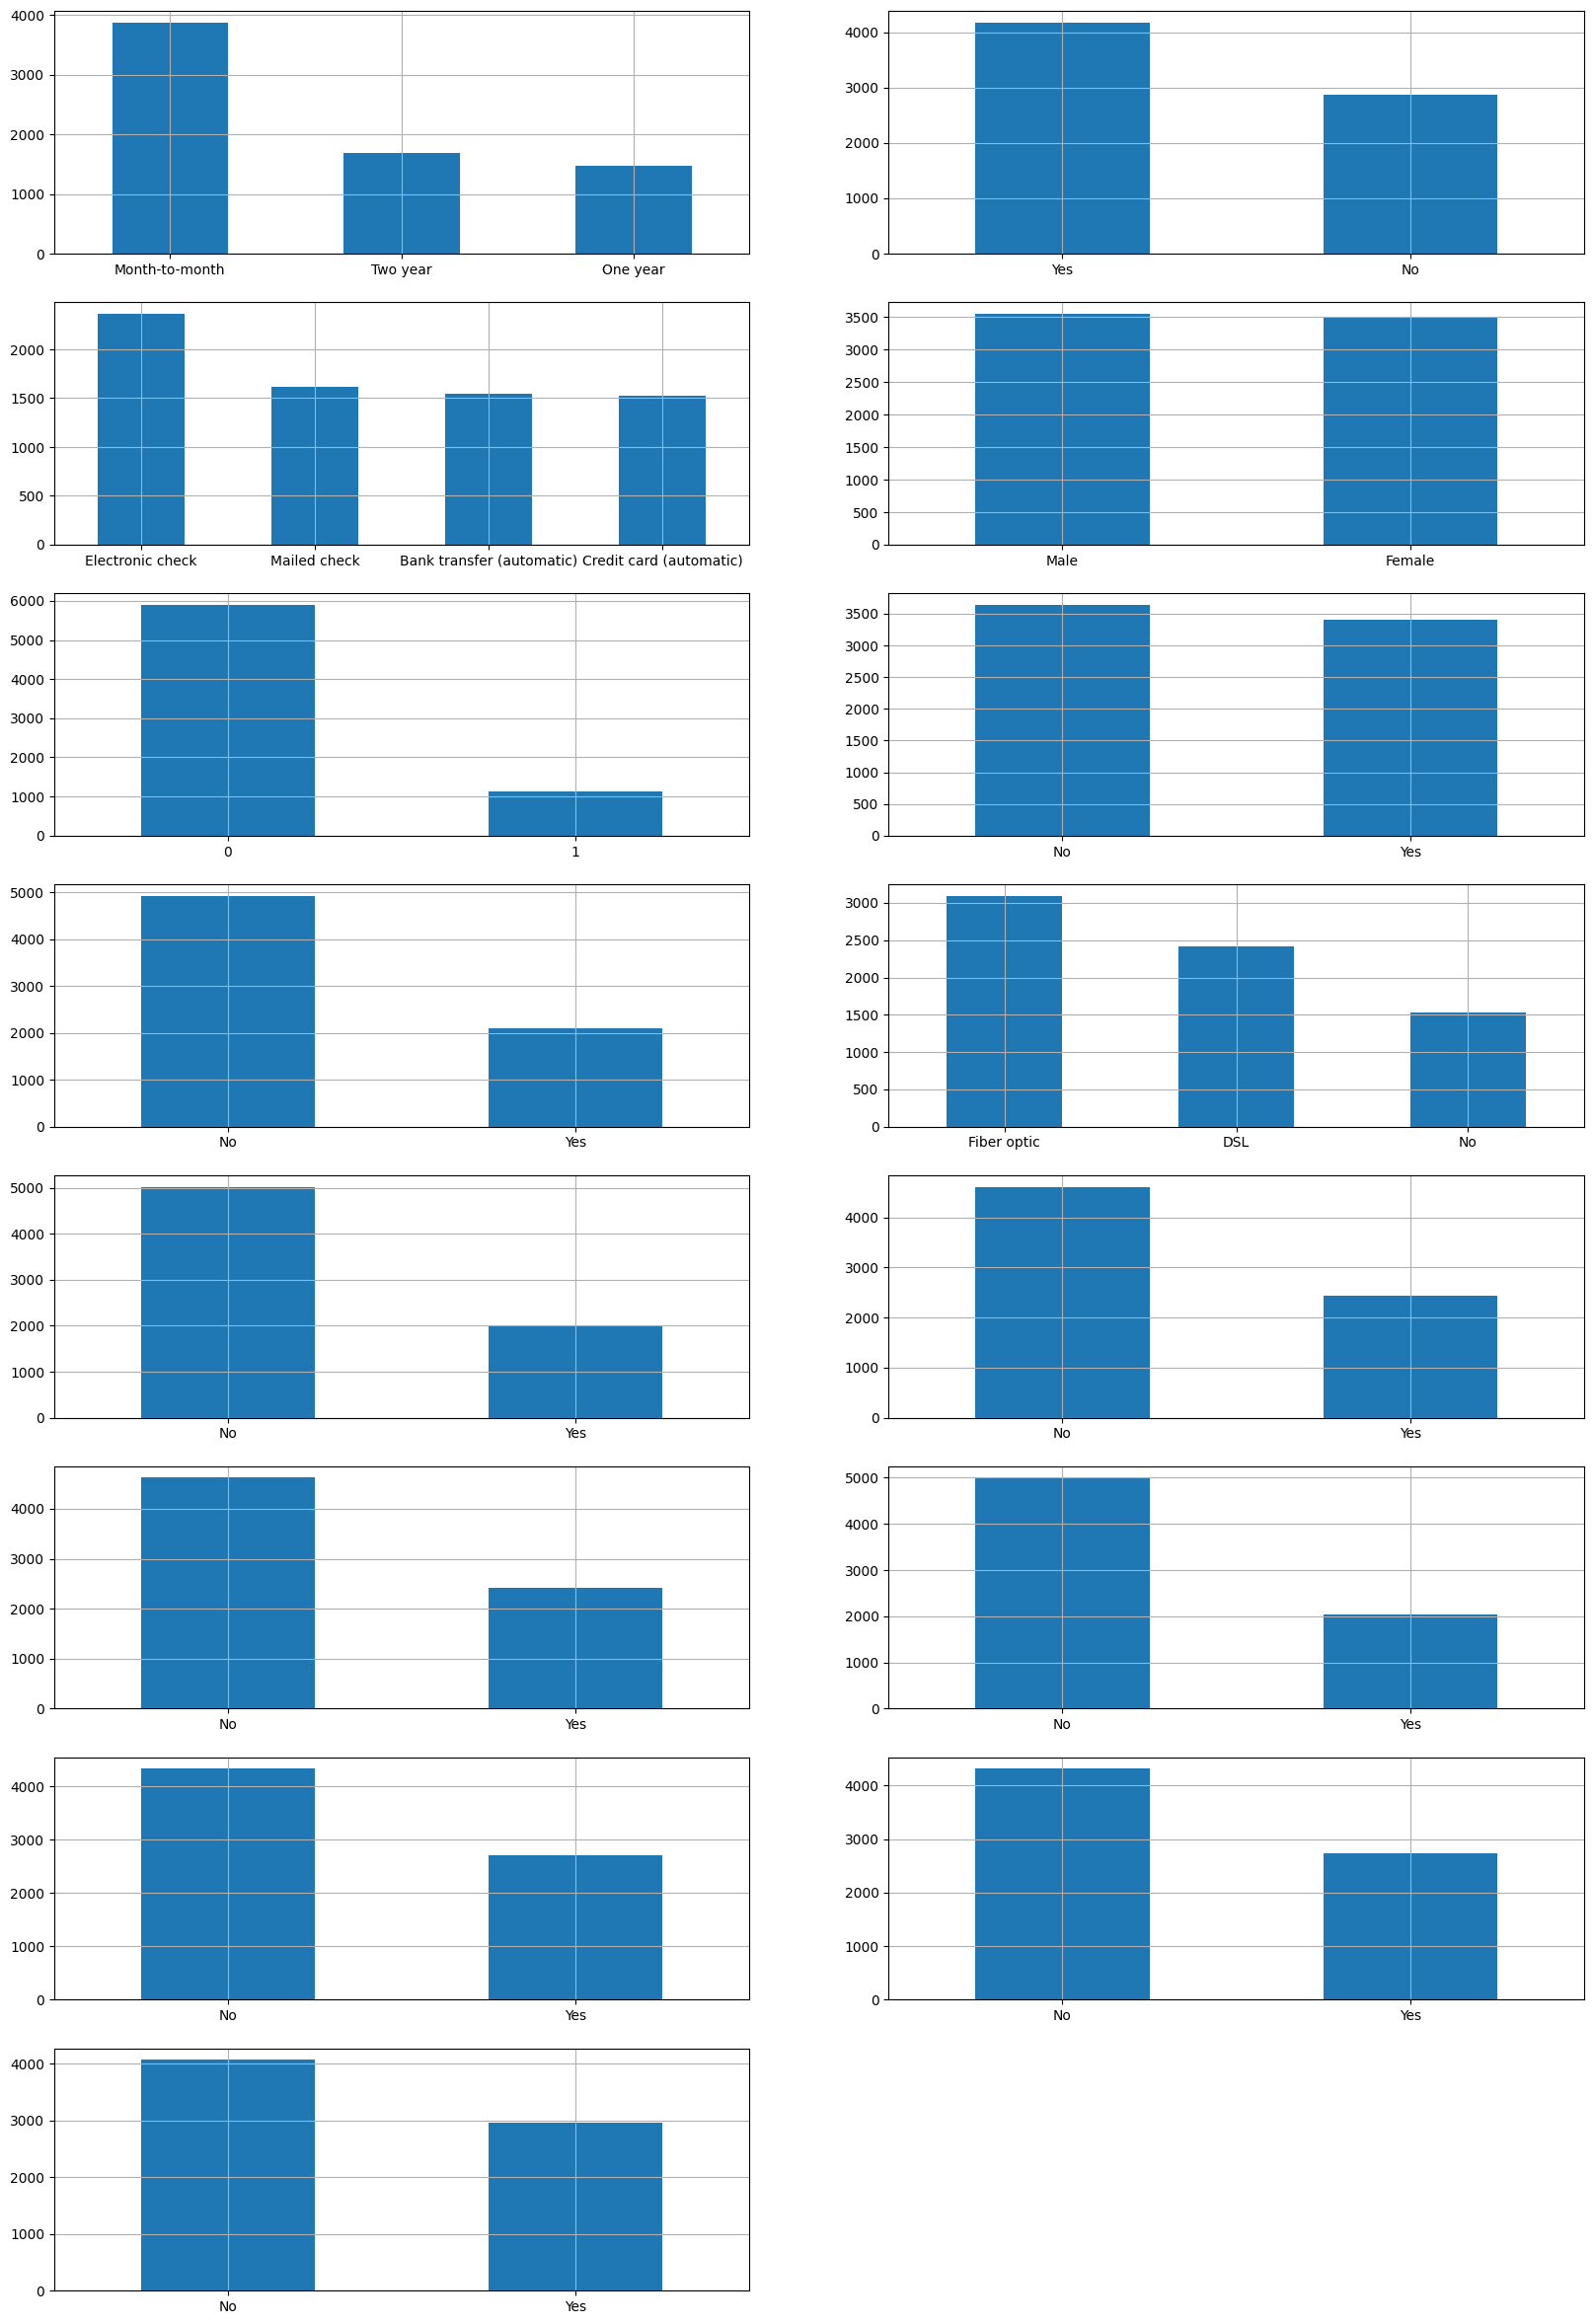

In [24]:
plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorical):
    ax = plt.subplot(8, 2, idx + 1)
    
    df[column].value_counts().plot(
        kind='bar', 
        ax=ax,
        rot=0,
    )
    ax.grid()
    
plt.show()
        

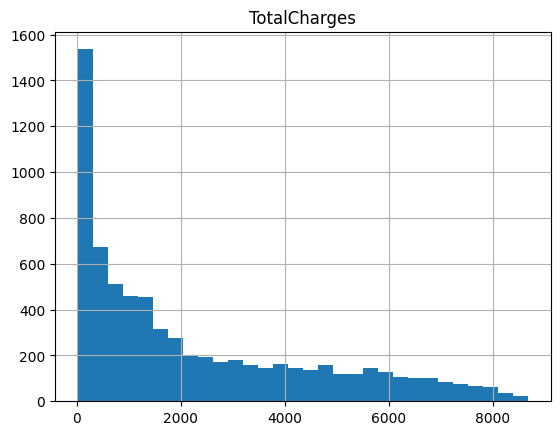

In [25]:
plt.hist(df['TotalCharges'], bins=30)
plt.title('TotalCharges')
plt.grid(True)

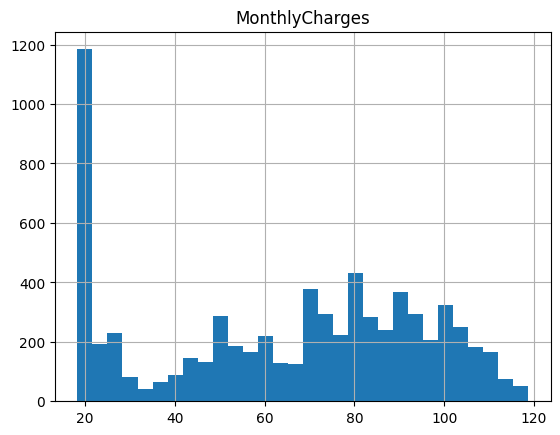

In [26]:
plt.hist(df['MonthlyCharges'], bins=30)
plt.title('MonthlyCharges')
plt.grid(True)

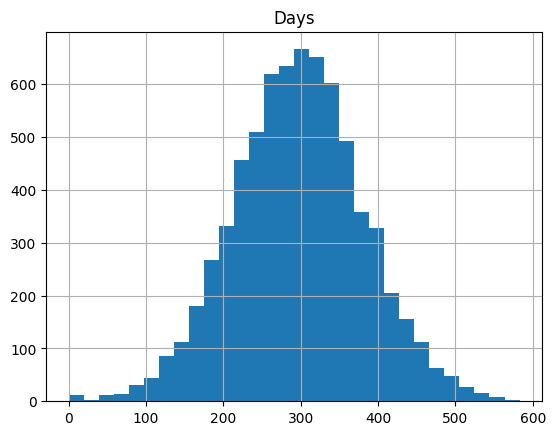

In [27]:
plt.hist(df['Days'], bins=30)
plt.title('Days')
plt.grid(True)

### Вывод:
Заполнены пропуски.

Добавлен признак дней.

Проверена корелляция количественных факторов с целевым признаком.

## Обучение модели

In [28]:
df = df[categorical + continuous + [target]]

In [29]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

features_train = df_train[categorical + continuous]
target_train = df_train[target]

features_test = df_test[categorical + continuous]
target_test = df_test[target]

In [30]:
continuous_pipeline = Pipeline([('scaler', StandardScaler())])

linear_processor = ColumnTransformer(transformers=[
    ('number', continuous_pipeline, continuous),
    ('category', Pipeline([('OHE', OneHotEncoder())]), categorical)
])

boosting_processor = ColumnTransformer(transformers=[
    ('number', continuous_pipeline, continuous),
    ('category', Pipeline([('OE', OrdinalEncoder())]), categorical)
])


### LogisticRegression

In [31]:
lr_pl = Pipeline([('preprocess', linear_processor), ('ro', RandomOverSampler()), ('clf', LogisticRegression())])
grid = GridSearchCV(lr_pl, param_grid={}, cv=3, scoring='f1')
model_lr = grid.fit(features_train, target_train)

In [32]:
print(f'F1 = {model_lr.best_score_}')

F1 = 0.8004274700578993


### CatBoostClassifier

In [33]:
cb_pl = Pipeline([('preprocess', boosting_processor), ('ro', RandomOverSampler()), ('clf', CatBoostClassifier(verbose=300))])

grid_space = {'clf__depth': [5], 'clf__l2_leaf_reg': [9], 'clf__learning_rate': [0.1]}
# grid_space = {
#     'clf__learning_rate': [0.1, 0.3],
#     # 'iterations': [50, 100],
#     'clf__depth': [3, 5],
#     'clf__l2_leaf_reg': [3, 9]
# }

grid = GridSearchCV(cb_pl, param_grid=grid_space, cv=3, scoring='f1')
model_cb = grid.fit(features_train, target_train)

0:	learn: 0.6530556	total: 64.7ms	remaining: 1m 4s
300:	learn: 0.2928187	total: 1.14s	remaining: 2.64s
600:	learn: 0.2088402	total: 2.2s	remaining: 1.46s
900:	learn: 0.1557272	total: 3.25s	remaining: 357ms
999:	learn: 0.1434133	total: 3.65s	remaining: 0us
0:	learn: 0.6507796	total: 2.93ms	remaining: 2.93s
300:	learn: 0.2806067	total: 1.08s	remaining: 2.51s
600:	learn: 0.1964134	total: 2.12s	remaining: 1.41s
900:	learn: 0.1467231	total: 3.18s	remaining: 350ms
999:	learn: 0.1347124	total: 3.54s	remaining: 0us
0:	learn: 0.6464534	total: 8ms	remaining: 8s
300:	learn: 0.2777252	total: 1.2s	remaining: 2.8s
600:	learn: 0.1990652	total: 2.3s	remaining: 1.52s
900:	learn: 0.1496669	total: 3.59s	remaining: 395ms
999:	learn: 0.1387467	total: 4.05s	remaining: 0us
0:	learn: 0.6505821	total: 3.2ms	remaining: 3.2s
300:	learn: 0.3295129	total: 2.04s	remaining: 4.74s
600:	learn: 0.2508750	total: 3.46s	remaining: 2.3s
900:	learn: 0.2024434	total: 4.99s	remaining: 548ms
999:	learn: 0.1901380	total: 5.54s	

In [34]:
print(f'F1 = {model_cb.best_score_}')

F1 = 0.8397405092823135


In [35]:
best_estimator = model_cb.best_estimator_

### Вывод:
CatBoost показал лучшие результаты.

Дисбаланс устранил через upsample (RandomOverSampler). downsample удалил, он показал значительно худшие результаты.

## Тестирование модели и демонстрация её работы

In [36]:
best_estimator.fit(features_train, target_train)
predict = best_estimator.predict(features_test)
print(f'F1 = {f1_score(target_test, predict)}')

0:	learn: 0.6494653	total: 4.8ms	remaining: 4.8s
300:	learn: 0.3236659	total: 1.5s	remaining: 3.48s
600:	learn: 0.2476013	total: 3.18s	remaining: 2.11s
900:	learn: 0.1977341	total: 4.47s	remaining: 491ms
999:	learn: 0.1860450	total: 5.05s	remaining: 0us
F1 = 0.8373397435897436


In [37]:
feature_importances = pd.DataFrame(best_estimator._final_estimator.feature_importances_, index=df.columns.drop(target), columns=['importances']).sort_values(by='importances')
display(feature_importances)

,importances
StreamingMovies,1.308541
Days,1.559210
OnlineSecurity,1.669942
InternetService,1.722237
OnlineBackup,1.741958
StreamingTV,1.763540
Dependents,1.874925
MonthlyCharges,1.951851
MultipleLines,2.027172
TotalCharges,2.072269


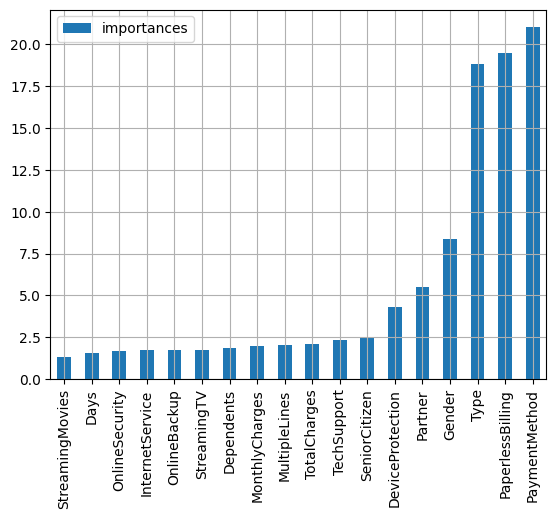

In [38]:
feature_importances.plot(kind='bar')
plt.grid()
None

In [39]:
feature_importances.tail(5)

,importances
Partner,5.507634
Gender,8.378748
Type,18.820579
PaperlessBilling,19.479470
PaymentMethod,21.011070


### Вывод:

После использования CatBoostClassifier точность достигла 0.837

Основные факторы:

- DeviceProtection антивирус
- Type тип оплаты: раз в год-два или ежемесячно;
- Gender пол
- PaymentMethod тип платежа;
- PaperlessBilling электронный расчётный лист;

Таким образом, чтобы снизить отток клиентов, можно предлагать скидки тем, кто оплачивает интернет в электронном виде и сразу за год.

Если человек уже заплатил заранее и получает электронный чек, то он менее вероятно откажется от услуг.